# Modeling and Predictions

[Notebook 1: EDA and Cleaning](./1_EDA and Cleaning.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling and Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

1. Features
2. Resampling
3. Modeling
    - Scaling
    - Lagged features
    - Train test split, fit models, evaluate

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import time

import matplotlib
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm

from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

In [2]:
matplotlib.rcParams['figure.figsize'] = (13, 8)

In [3]:
# Read in pickle.
data = pd.read_pickle('./pickle.pkl')

# Features

In [4]:
# Add hours feature
data['Hour'] = data.index.hour

In [38]:
# Get features
features = ['DOY', 'DNI', 'Air Temp', 'Hour', 'Humidity', 'Pressure', 'Wind Speed', 'Wind Dir', 'Azimuth', 'Zenith', 'Precipitation']
label = ['DNI']

# Resampling
Resampling data to reduce runtime. Resampling during the period where the battery did not hold a charge, we see the  missing raw data.

In [77]:
data_re = data[features].resample('15T').mean()

In [78]:
data_re.sort_index(inplace=True)

In [79]:
print(data_re[data_re['DNI'].isnull()])

                     DOY  DNI  Air Temp  Hour  Humidity  Pressure  Wind Speed  \
datetime                                                                        
2014-12-03 18:30:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 18:45:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 19:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 19:15:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 19:30:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 19:45:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 20:00:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 20:15:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 20:30:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 20:45:00  NaN  NaN       NaN   NaN       NaN       NaN         NaN   
2014-12-03 21:00:00  NaN  Na

In [80]:
data_re.dropna(axis=0, inplace=True)

# Modeling

## Scaling

In [81]:
# Save num features for shaping later
feat_count = len(data_re.columns)

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data_re)
scaled = pd.DataFrame(scaled, index=data_re.index, columns=data_re.columns)

## Lagged features

In [83]:
# Create df of all lagged features

lags = [24*4, 168*4]
lstm_data = pd.DataFrame()
lagged_feat_dict = {}

for x in lags:
    
    # shift
    lagged_data = scaled[features].shift(periods=x).dropna() # drop after looping
    
    # rename lagged features
    lagged_col_names = {}
    for y in lagged_data.columns:
        lagged_col_names[y] = y + '_' + str(x)
    lagged_data.rename(columns=lagged_col_names, inplace=True)
    
    # make dict of lagged_col_names (to reference for later)
    lagged_feat_dict[x] = lagged_col_names.values()
        
    # make lstm_data the lagged data
    lstm_data = pd.concat([lstm_data, lagged_data], axis=1)
    
# Add DNI target
lstm_data = pd.concat([lstm_data, scaled[label]], axis=1)

## Train test split, fit models, evaluate

Training w/ lag 96
Train on 60829 samples, validate on 113369 samples
Epoch 1/10
60829/60829 [==============================] - 48s 781us/step - loss: 0.0535 - val_loss: 0.0440
Epoch 2/10
60829/60829 [==============================] - 45s 734us/step - loss: 0.0494 - val_loss: 0.0448
Epoch 3/10
60829/60829 [==============================] - 45s 734us/step - loss: 0.0485 - val_loss: 0.0459
Epoch 4/10
60829/60829 [==============================] - 45s 735us/step - loss: 0.0476 - val_loss: 0.0460
Epoch 5/10
60829/60829 [==============================] - 45s 734us/step - loss: 0.0472 - val_loss: 0.0465
Epoch 6/10
60829/60829 [==============================] - 45s 733us/step - loss: 0.0468 - val_loss: 0.0462
Epoch 7/10
60829/60829 [==============================] - 45s 737us/step - loss: 0.0465 - val_loss: 0.0460
Epoch 8/10
60829/60829 [==============================] - 45s 738us/step - loss: 0.0463 - val_loss: 0.0460
Epoch 9/10
60829/60829 [==============================] - 45s 736us/step -

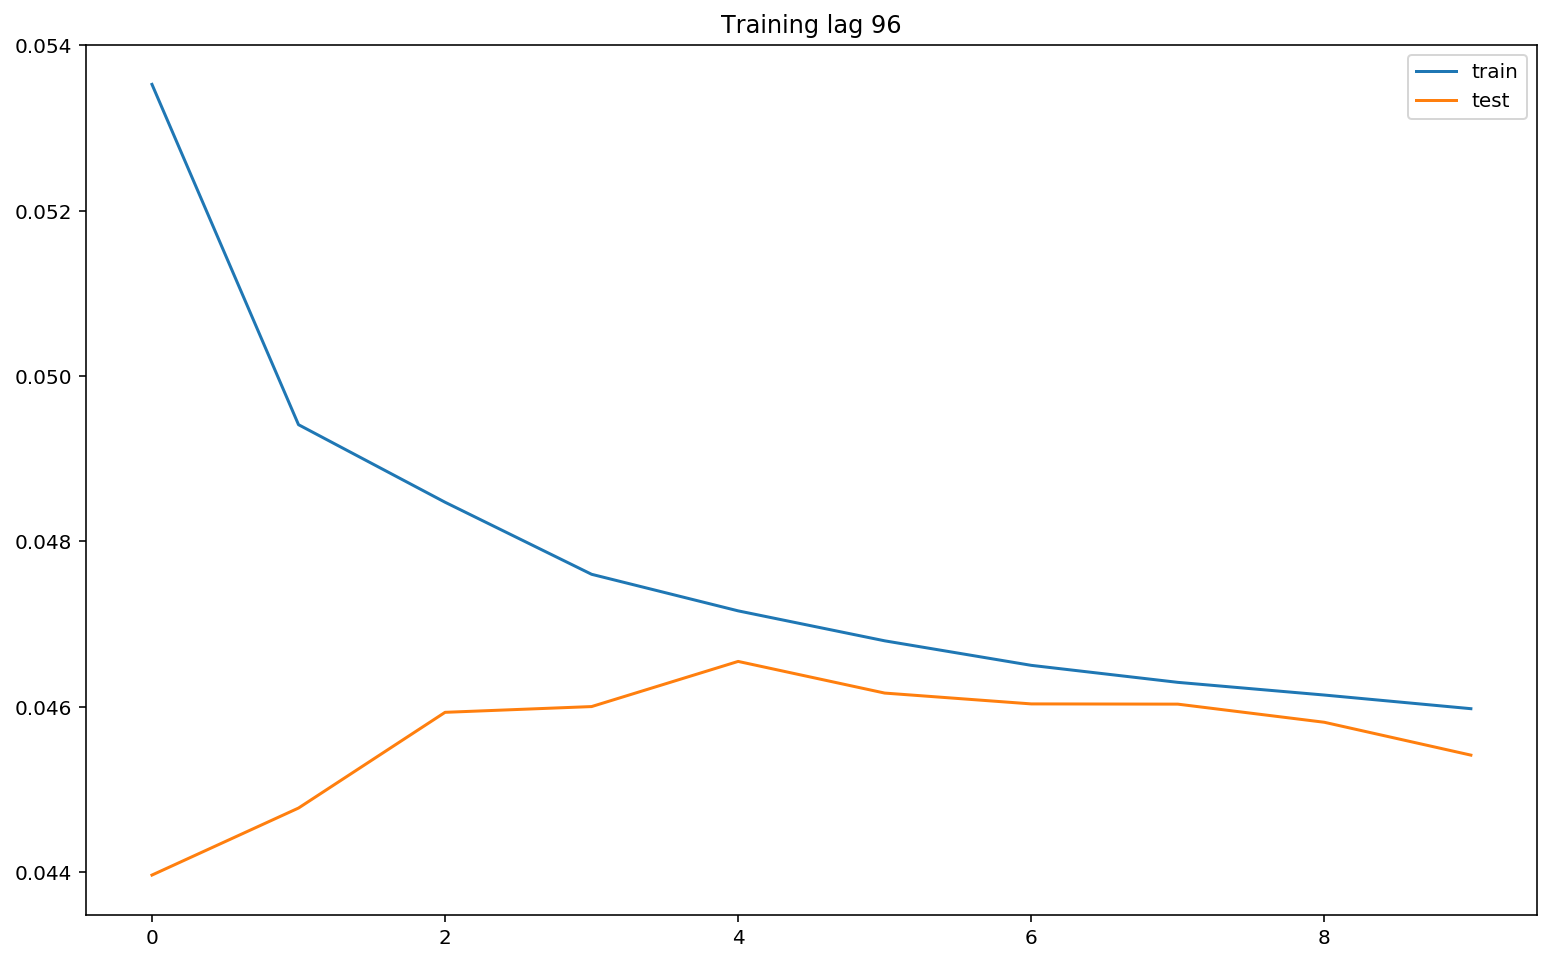

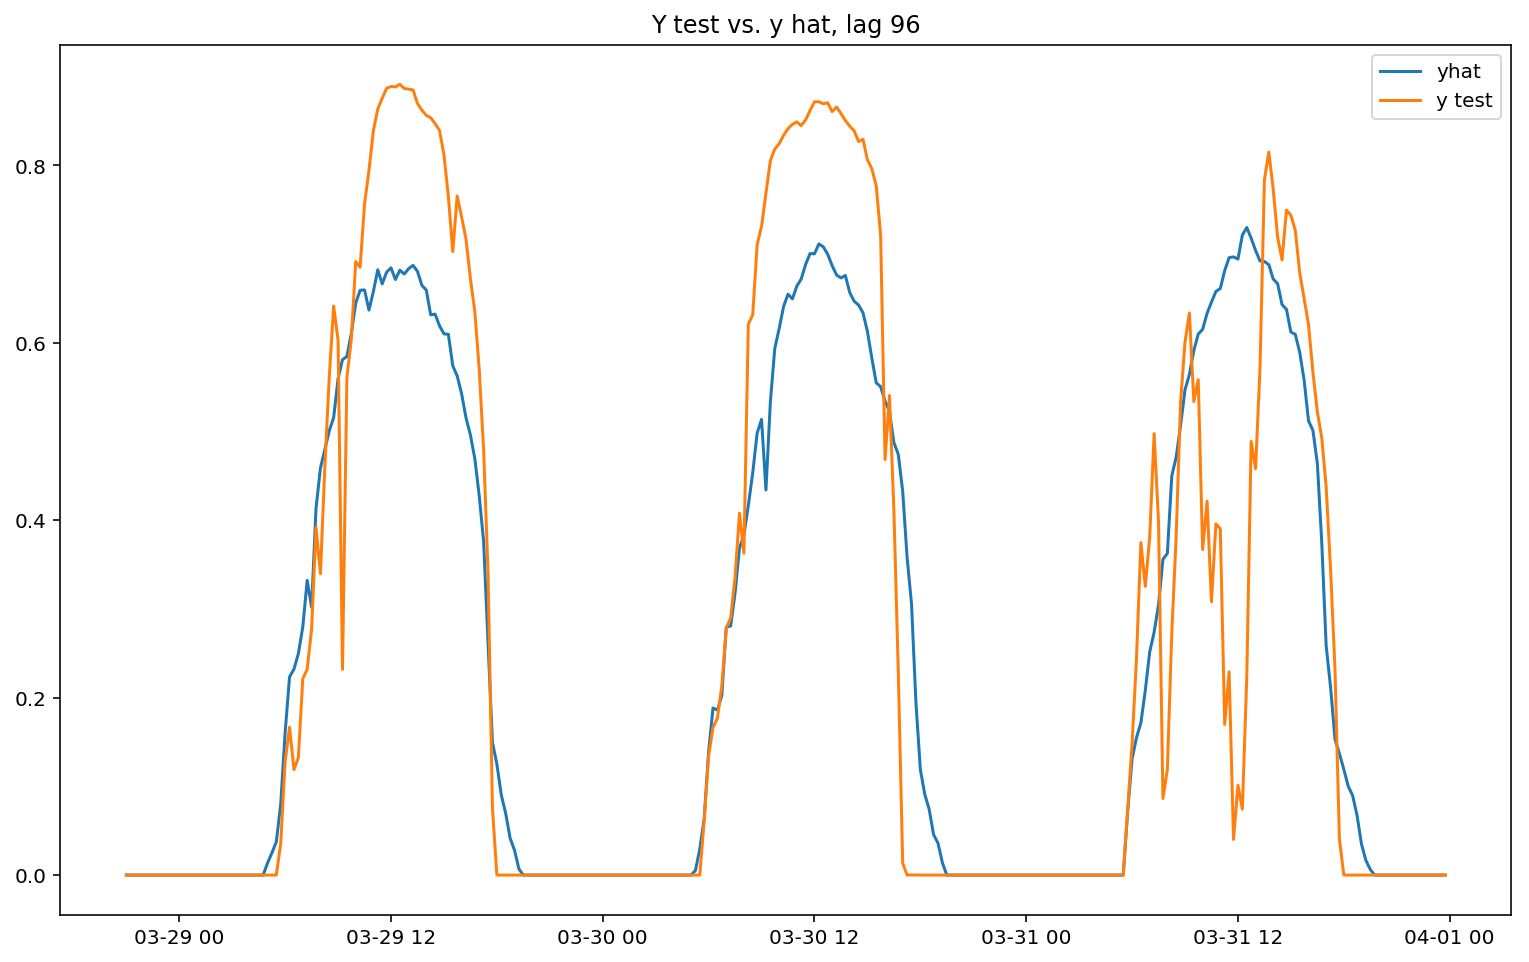

96 hours lag test R2 score: 0.508
96 hours lag test RMSE: 0.207
RMSE in DNI (W/m2): 214.437

Training w/ lag 672
Train on 60253 samples, validate on 113369 samples
Epoch 1/10
60253/60253 [==============================] - 627s 10ms/step - loss: 0.0607 - val_loss: 0.0618
Epoch 2/10
60253/60253 [==============================] - 656s 11ms/step - loss: 0.0579 - val_loss: 0.0672
Epoch 3/10
60253/60253 [==============================] - 638s 11ms/step - loss: 0.0561 - val_loss: 0.0784
Epoch 4/10
60253/60253 [==============================] - 633s 10ms/step - loss: 0.0554 - val_loss: 0.0821
Epoch 5/10
60253/60253 [==============================] - 647s 11ms/step - loss: 0.0553 - val_loss: 0.0813
Epoch 6/10
60253/60253 [==============================] - 641s 11ms/step - loss: 0.0551 - val_loss: 0.0797
Epoch 7/10
60253/60253 [==============================] - 653s 11ms/step - loss: 0.0549 - val_loss: 0.0766
Epoch 8/10
60253/60253 [==============================] - 649s 11ms/step - loss: 0.0548

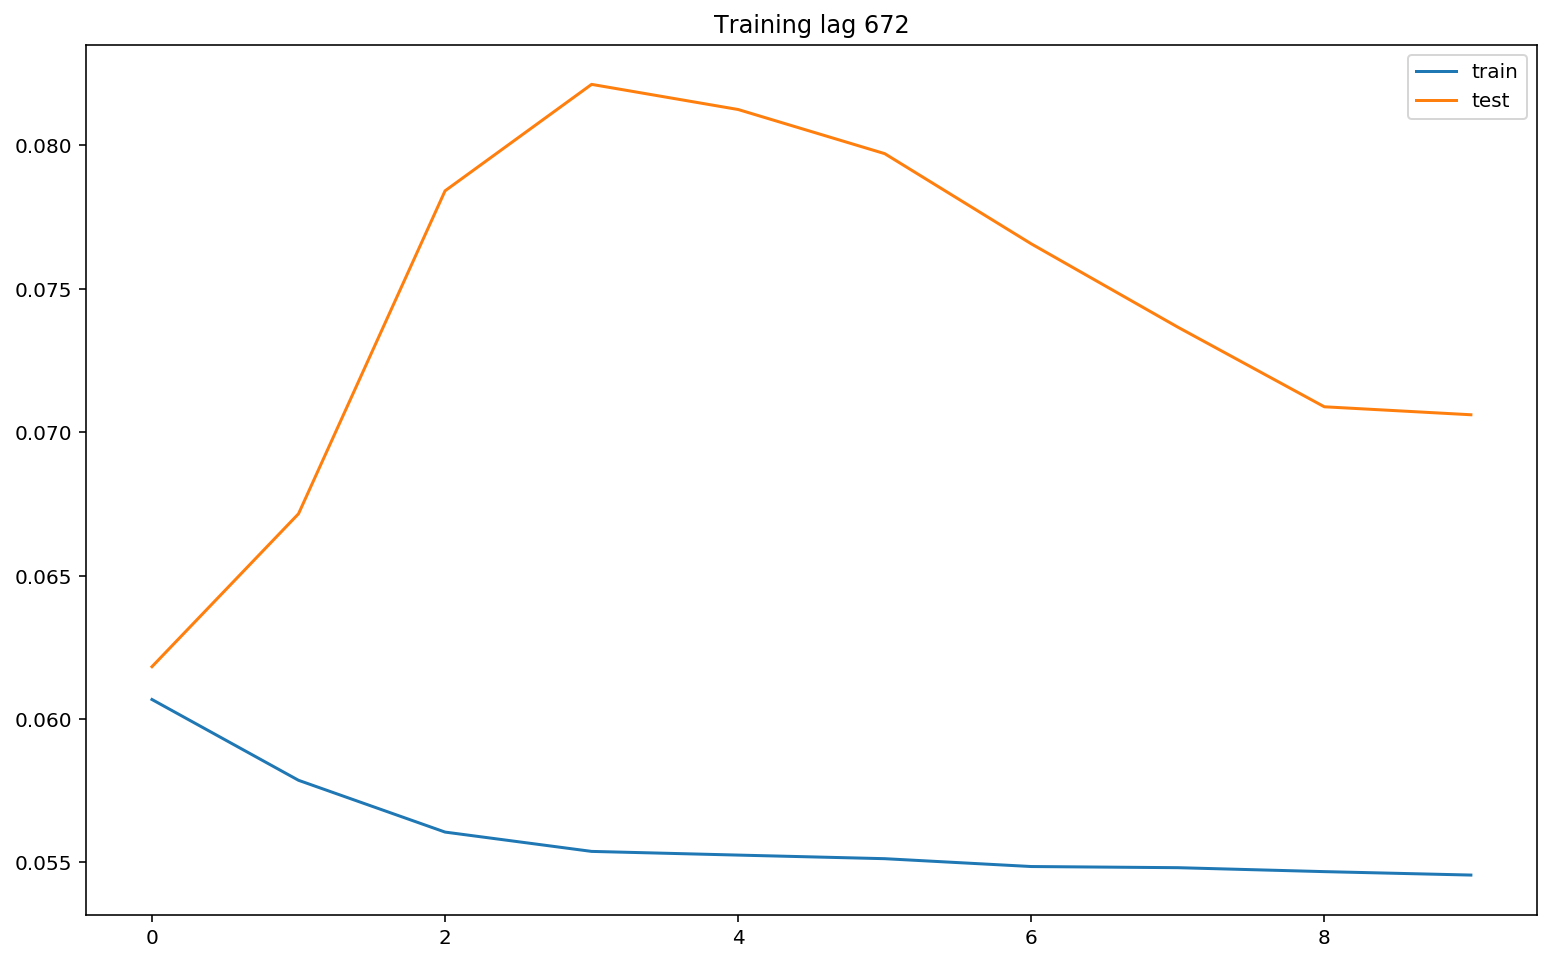

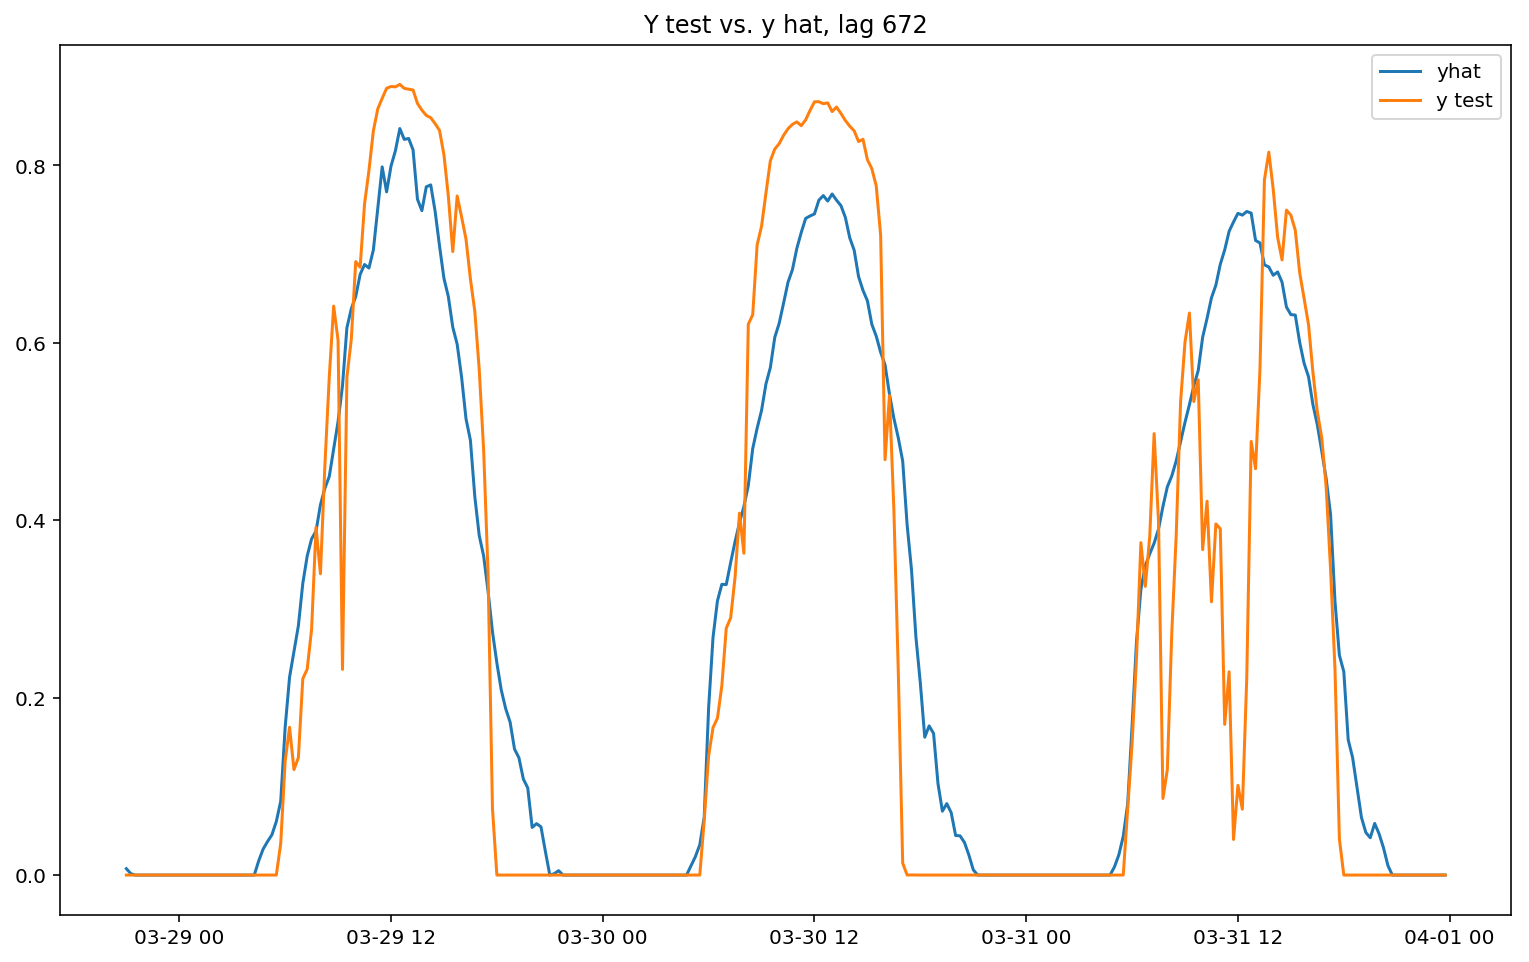

672 hours lag test R2 score: 0.364
672 hours lag test RMSE: 0.264
RMSE in DNI (W/m2): 273.670



In [95]:
year = 2012

tts = len(lstm_data.loc[lstm_data.index.year < year])

model_results = []

epochs_ = 10
batch_size_ = 12
dropout_ = .3

for x in lags:
    
    print('Training w/ lag', x)
    
    feats = list(lagged_feat_dict[x])
    
    lstm_temp = lstm_data[feats + ['DNI']].dropna()
    lstm_train = lstm_temp.loc[lstm_temp.index.year < year]
    lstm_test = lstm_temp.loc[lstm_temp.index.year >= year]
    
    X_train = lstm_train[feats].values
    X_test = lstm_test[feats].values
    y_train = lstm_train['DNI'].values
    y_test = lstm_test['DNI'].values
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # comment out this box and uncomment load_model to load saved model
    #############################################################################
                                                                                #
    # design network                                                            #
    model = Sequential()                                                        #
    model.add(LSTM(int(x), input_shape=(X_train.shape[1], X_train.shape[2])))   #
    model.add(Dropout(dropout_))                                                #
    model.add(Dense(1))                                                         #
    model.compile(loss='mean_squared_error', optimizer='adam')                  #
                                                                                #
    # fit network                                                               #
    history = model.fit(X_train,                                                #
                        y_train,                                                #
                        epochs=epochs_,                                         #
                        batch_size=batch_size_,                                 #
                        validation_data=(X_test, y_test),                       #
                        verbose=1,                                              #
                        shuffle=False)                                          #
                                                                                #
    # Save model for later                                                      #
    filename = str(int(time.time())) + '_model_' + str(x) + '_lag.h5'           #
    model.save('./models/' + filename)                                          #
                                                                                #
    #############################################################################
    
    # uncomment to load 
    #model = load_model('./models/1539911055_model_672_lag.h5')
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training lag ' + str(x))
    plt.show()

    # make a prediction
    yhat = model.predict(X_test)
    
    # sets floor for yhat
    yhat = [x[0] if x > 0 else 0 for x in yhat]
    
    # Concat y_hat to dataframe for later
    lstm_test = pd.concat([lstm_test, pd.DataFrame(yhat, columns=['yhat'], index=lstm_test.index)], axis=1)
    
    # Invert scaling (so we can get our forecast and evaluation in terms of DNI (W/m2))

    # Get yhat and y_test
    yhat = lstm_test['yhat']
    original = lstm_test['DNI']

    # Copy lstm_test
    lstm_test_yhat = lstm_test.iloc[:, :feat_count]
    lstm_test_original = lstm_test.iloc[:, :feat_count]

    # Substitute yhat and y_test into lstm_test
    lstm_test_yhat.iloc[:, 1] = yhat
    lstm_test_original.iloc[:, 1] = original

    # Inverse yhat
    inv_yhat = scaler.inverse_transform(lstm_test_yhat)
    inv_yhat = pd.DataFrame(inv_yhat).iloc[:, 1]

    # Inverse y_test
    inv_y_test = scaler.inverse_transform(lstm_test_original)
    inv_y_test = pd.DataFrame(inv_y_test).iloc[:, 1]
          
    hours = 300

    plt.plot(yhat[-hours:], label='yhat')
    plt.plot(original[-hours:], label='y test')
    plt.legend()
    plt.title('Y test vs. y hat, lag ' + str(x))
    
    plt.show()
    
    # # calculate RMSE
    rmse = sqrt(mean_squared_error(yhat, y_test))
    r2 = r2_score(yhat, y_test)
    
    # Metrics printout
    print('R2 score: %.3f' % r2)
    print('RMSE: %.3f' % rmse)
    print('RMSE (in DNI (W/m2)): %.3f' % sqrt(mean_squared_error(inv_y_test, inv_yhat)))
    
    print()
    
    # Save all the results
    
    model_results_dict = {}
    
    model_results_dict['tts_year'] = year
    model_results_dict['lag'] = x
    model_results_dict['dropout'] = dropout_
    model_results_dict['epochs'] = epochs_
    model_results_dict['batch_size'] = batch_size_
    model_results_dict['params'] = history.params
    model_results_dict['loss'] = history.history
    model_results_dict['rmse'] = rmse
    model_results_dict['dni_rmse'] = sqrt(mean_squared_error(inv_y_test, inv_yhat))
    model_results_dict['r2'] = r2
    model_results_dict['model_filename'] = filename
    model_results_dict['time_ran'] = int(time.time())
    
    model_results_dict['notes'] = '30m resample'
    
    model_results.append(model_results_dict)
    
# Reads in old results and concats with new results

new_res_df = pd.DataFrame(model_results)
old_res_df = pd.read_csv('./results/results.csv', index_col=0)
res_df = pd.concat([old_res_df, new_res_df], axis=0, sort=False).reset_index(drop=True)
res_df.to_csv('./results/results.csv')

In [98]:
res_df.sort_values(by='r2', ascending=False).head()

,batch_size,dni_rmse,dropout,epochs,lag,loss,model_filename,params,r2,rmse,time_ran,tts_year,notes
21,12,214.437154,0.30,10,96,"{'val_loss': [0.04396318000442991, 0.044773910...",1539904618_model_96_lag.h5,"{'batch_size': 12, 'epochs': 10, 'steps': None...",0.507808,0.207093,1.539905e+09,2012,30m resample
19,24,209.795202,0.30,10,48,"{'val_loss': [0.04478426357989843, 0.043335489...",1539902151_model_48_lag.h5,"{'batch_size': 24, 'epochs': 10, 'steps': None...",0.483844,0.202637,1.539902e+09,2012,30m resample
22,12,273.670022,0.30,10,672,"{'val_loss': [0.061821492025508316, 0.06715392...",1539911055_model_672_lag.h5,"{'batch_size': 12, 'epochs': 10, 'steps': None...",0.363790,0.264297,1.539911e+09,2012,30m resample
20,24,264.784440,0.30,10,336,"{'val_loss': [0.07115563879104146, 0.068872127...",1539902818_model_336_lag.h5,"{'batch_size': 24, 'epochs': 10, 'steps': None...",0.363069,0.255750,1.539903e+09,2012,30m resample
12,1,190.897753,0.33,10,6,"{'val_loss': [0.04281447349751669, 0.042439634...",1539889446_model_6_lag.h5,"{'batch_size': 1, 'epochs': 10, 'steps': None,...",0.225731,0.194453,1.539889e+09,2013,4h resampling
